In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [2]:
%%capture
!pip install imblearn
!pip install xgboost

In [49]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, roc_auc_score, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
train_data = pd.read_csv("./train.csv")

In [5]:
train_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [7]:
train_data.nunique()

id                      11504798
Gender                         2
Age                           66
Driving_License                2
Region_Code                   54
Previously_Insured             2
Vehicle_Age                    3
Vehicle_Damage                 2
Annual_Premium             51728
Policy_Sales_Channel         152
Vintage                      290
Response                       2
dtype: int64

In [8]:
# checking duplicate data
train_data.duplicated().sum()

0

In [9]:
# checking missing values
train_data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### EDA

In [10]:
class Visualization:
    def __init__(self, df):
        self.df = df
        
    def format_func(self, value, tick_number):
        if value >= 1000000:
            return f'{value / 1000000:.1f}M'
        elif value >= 1000:
            return f'{value / 1_000:.1f}K'
        else:
            return str(int(value))
    
    def combined_plot(self, cols, plt_fn, fig_size):
        n_col = 3
        n_row = (len(cols) + n_col - 1) // n_col
        fig, axes = plt.subplots(n_row, n_col, figsize=fig_size)
        axes = axes.flatten()
        
        for i, col in enumerate(cols):
            plt_fn(axes[i], col)
            
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
    
    def bar_plot(self, ax, col):
        df_col = self.df[col].value_counts()
        palette = sns.color_palette("Paired", len(df_col))
        colors = [palette[i] for i in range(len(df_col))]

        ax.bar(df_col.index, df_col.values, color = colors)
        ax.set_title(f"{col} Frequency")
        ax.set_xlabel(f"{col}")
        ax.set_ylabel(f"Frequency")
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(self.format_func))
        
    def hist_plot(self, ax, col):
        palette = sns.color_palette("tab10")
        ax.hist(self.df[col], color=palette[2])
        ax.set_title(f"{col} Histogram")
        ax.set_xlabel(f"{col}")
        ax.set_ylabel(f"Frequency")
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(self.format_func))
    
    def box_plot(self, ax, col):
        palette = sns.color_palette("flare")
        sns.boxplot(data=self.df, x=col, ax=ax, palette=palette)
        ax.set_title(f"{col} Box Plot")
    
    def pie_chart(self, ax, col):
        df_col = self.df[col].value_counts()
        palette = sns.color_palette("Paired", len(df_col))
        ax.pie(df_col.values, labels=df_col.index, autopct='%1.1f%%', colors=palette)
        ax.set_title(f"{col} Distribution")

In [11]:
gen_viz = Visualization(train_data)

In [12]:
nunq = train_data.nunique()
box_cols = nunq[nunq < 10].index

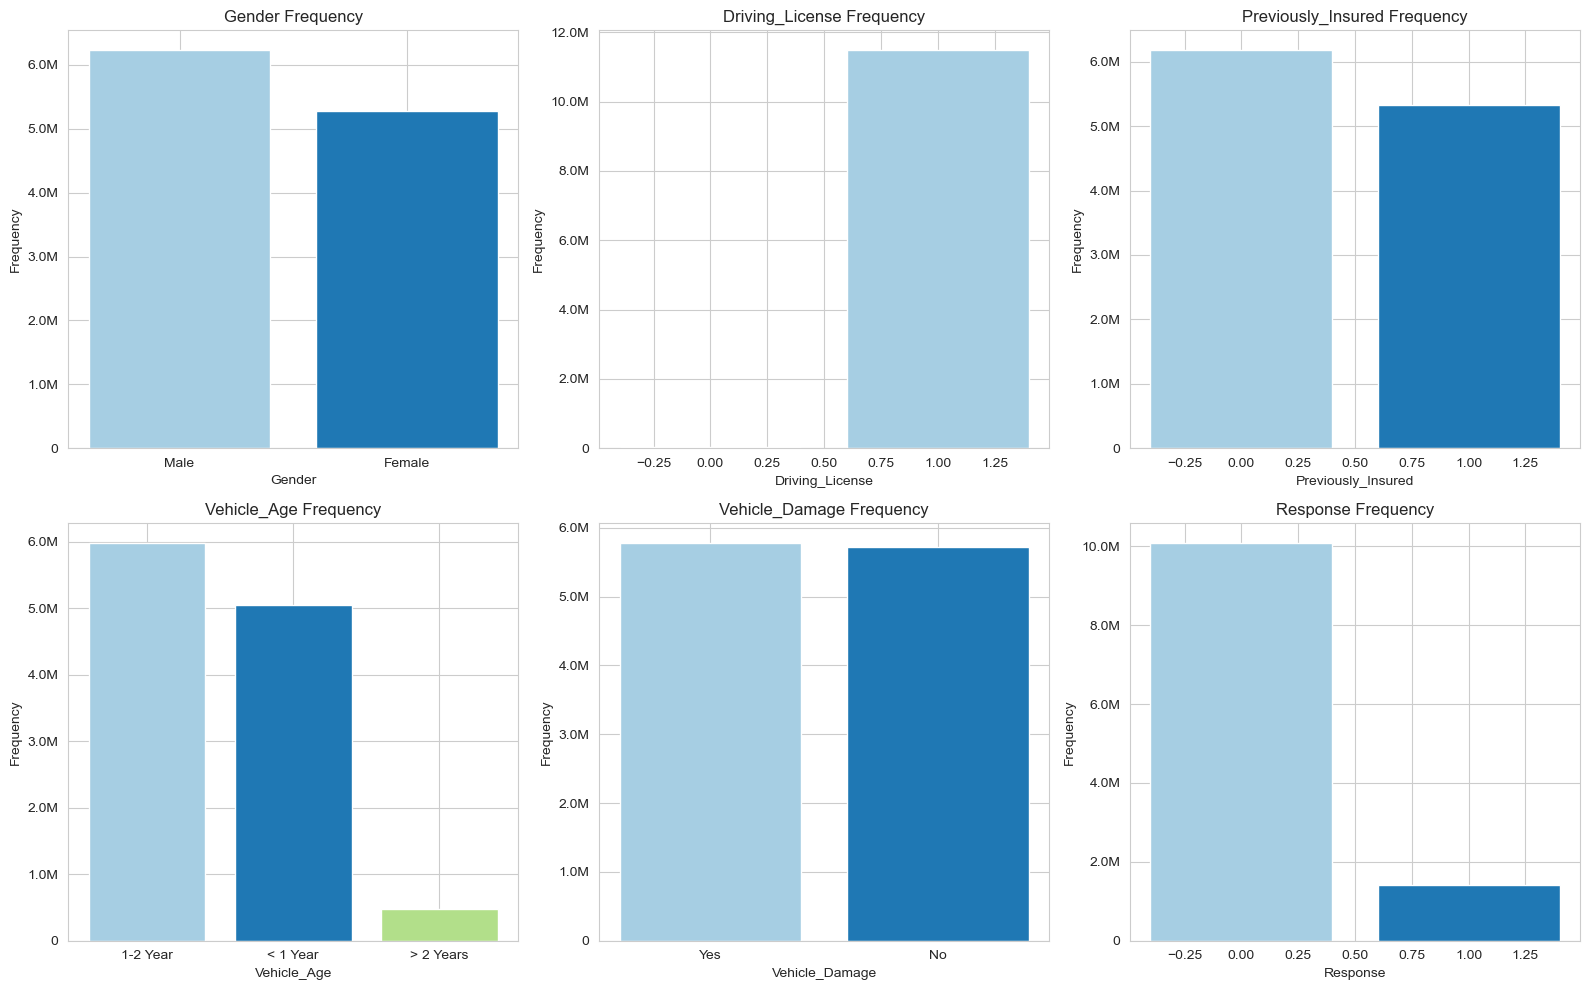

In [13]:
gen_viz.combined_plot(box_cols, gen_viz.bar_plot, (16, 10))

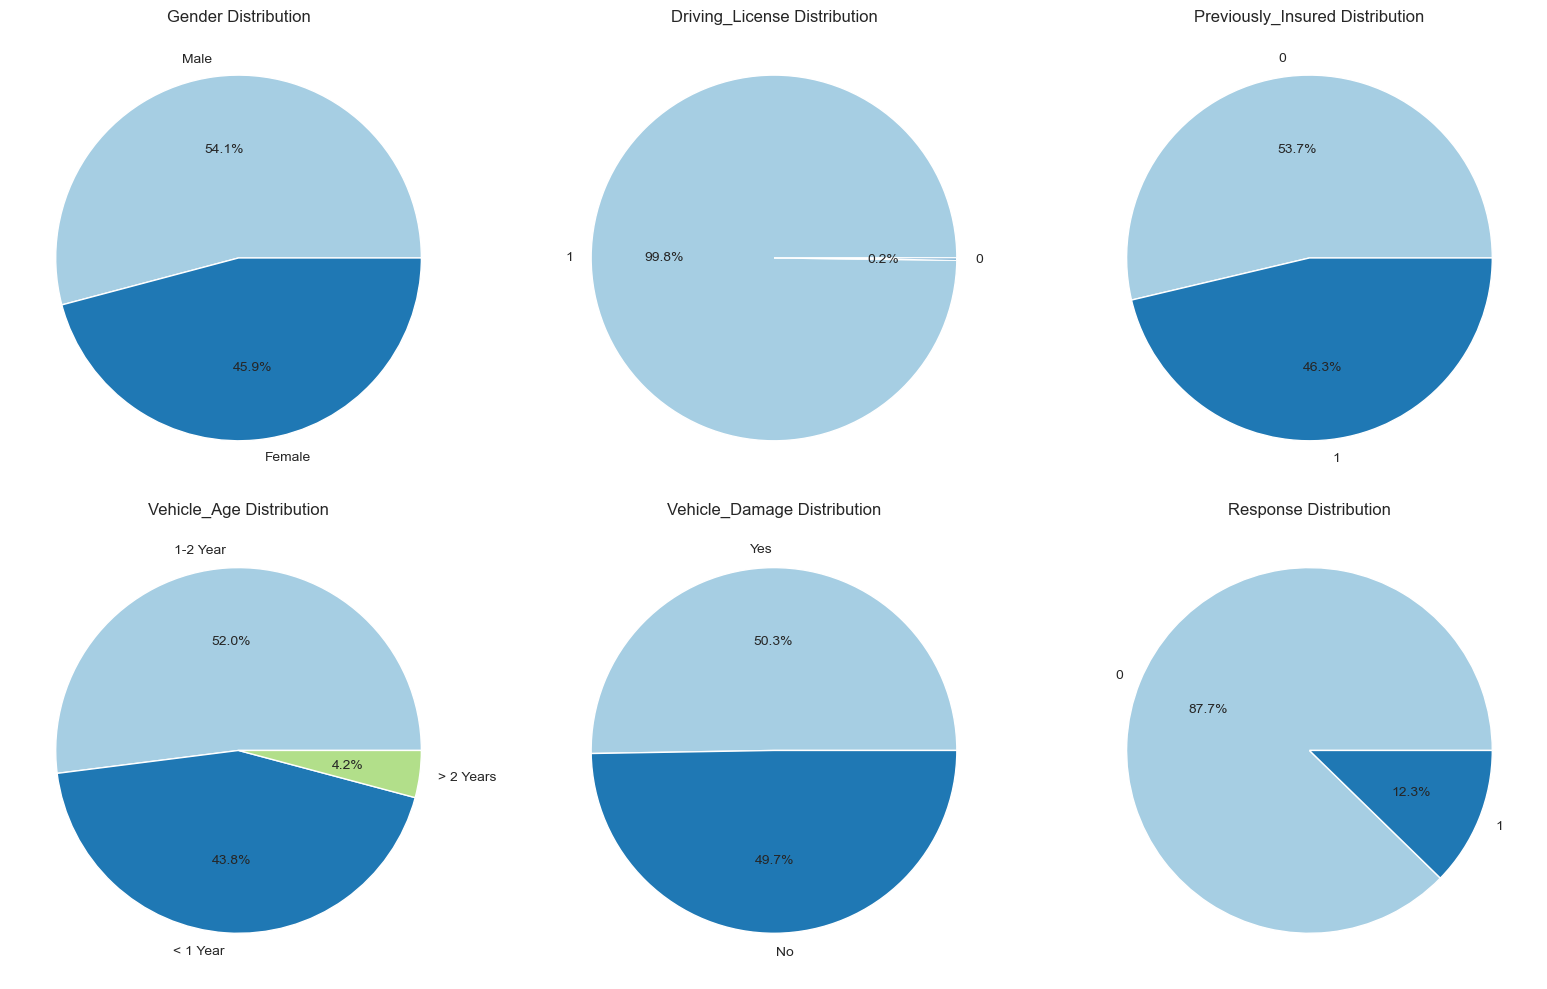

In [14]:
gen_viz.combined_plot(box_cols, gen_viz.pie_chart, (16, 10))

The data seems imbalanced so we need to make it balanced in-terms of the `Response` label.

In [15]:
hist_plot_cols = ['Age', 'Region_Code', 'Vehicle_Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

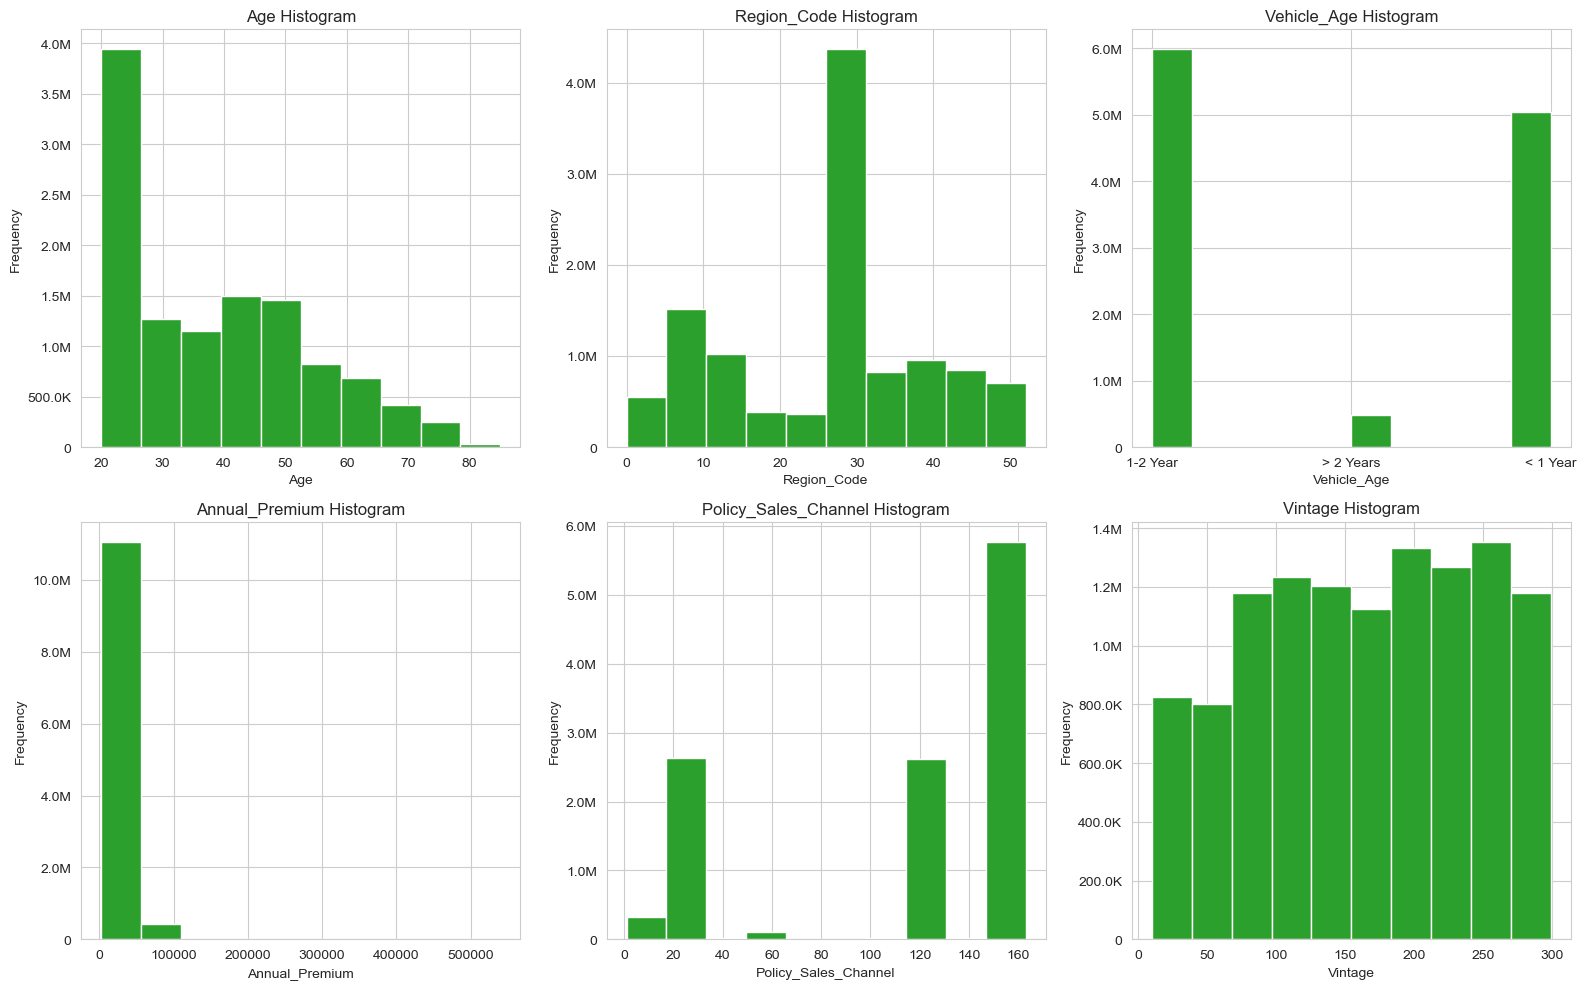

In [16]:
gen_viz.combined_plot(hist_plot_cols, gen_viz.hist_plot, (16, 10))

Few features seems to be skewed such as `Age`.

In [17]:
box_plt_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

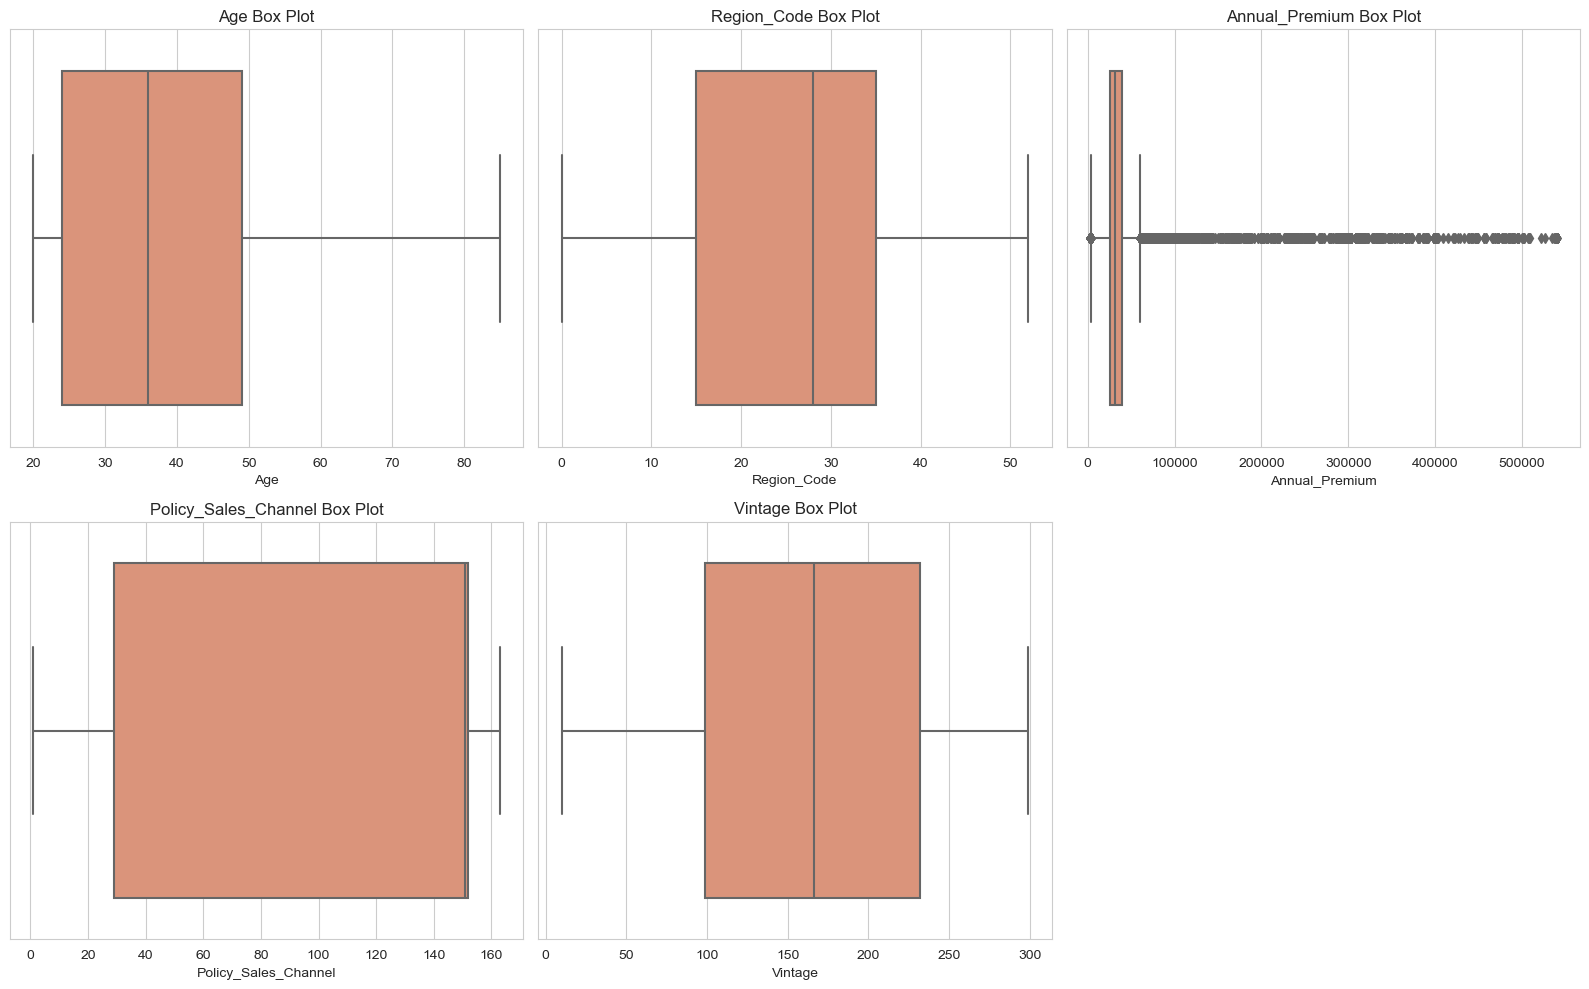

In [18]:
gen_viz.combined_plot(box_plt_cols, gen_viz.box_plot, (16, 10))

`Annual_Premium` seems to have more outliers than any one.

### Feature Engineering (Data Pre-processing)

In [19]:
# Encoding data using basic approach
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [20]:
class featureEncoding:
    def __init__(self, df):
        self.df = df
        self.obj_cols = df.select_dtypes(include=['object']).columns.tolist()
        self.encode = OneHotEncoder(sparse=False)
        
    def one_hot_enocde_pd(self):
        return pd.get_dummies(self.df, prefix=self.obj_cols, dtype = "float64")
    
    def one_hot_encode_sklearn(self):
        encoded_data = self.encode.fit_transform(self.df[self.obj_cols])
        
        encoded_df = pd.DataFrame(encoded_data, 
                                  columns = self.encode.get_feature_names_out(self.obj_cols))
        
        df_encoded = pd.concat([self.df, encoded_df], axis = 1)
        df_encoded.drop(self.obj_cols, axis = 1, inplace = True)
        
        return df_encoded

In [21]:
feat_encode = featureEncoding(train_data)

In [22]:
train_data = feat_encode.one_hot_enocde_pd()

#### Data Transformation
Scaling data to normalize the data

Balance the Imbalanced data

Log transformation of data to decrease skew

In [23]:
class transformData:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.smote = SMOTE()
        
    def scale_data(self, data):
        return self.scaler.fit_transform(data)
    
    def log_transform(self, data):
        return np.log1p(data)
    
    def transform(self, cols):
        log_transformer = FunctionTransformer(self.log_transform)
        df_log = self.df.copy()
        df_log[cols] = log_transformer.transform(self.df[cols])
        
        return df_log
    
    def balance_data(self, x, y):
        X_data, Y_data = self.smote.fit_resample(x, y)
        
        return X_data, Y_data

In [24]:
trans_data = transformData(train_data)

In [25]:
# Log transformation
skew_cols = ['Age']
train_data = trans_data.transform(skew_cols)

In [26]:
# Splitting target and features
X_feat = train_data.drop('Response', axis = 1)
y_tar = train_data['Response']

In [27]:
# SMOTE
X_feat_trans, y_tar_trans = trans_data.balance_data(X_feat, y_tar)

In [28]:
# Standard Scaling
X_feat_trans = trans_data.scale_data(X_feat_trans)

### Splitting the Data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_feat_trans,
                                                    y_tar_trans,
                                                    test_size = 0.3,
                                                    random_state = 42)

### Modeling

In [30]:
class classificationModel:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        
    def model_training(self):
        self.model.fit(self.X_train, self.y_train)
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)
        y_test_prob = self.model.predict_proba(self.X_test)[:, 1]
        
        return y_train_pred, y_test_pred, y_test_prob
        
    
    def model_evaluation(self, train_pred, test_pred, test_prob):
        train_acc = accuracy_score(self.y_train, train_pred)*100
        test_acc = accuracy_score(self.y_test, test_pred)*100
        test_f1 = f1_score(self.y_test, test_pred)
        test_pre = precision_score(self.y_test, test_pred)
        test_recall = recall_score(self.y_test, test_pred)
        test_roc_auc = roc_auc_score(self.y_test, test_prob)
        
        print(f"Model : {self.model}")
        print(f"Accuracy of Training Data: {train_acc}")
        print(f"Accuracy of Testing Data: {test_acc}")
        print(f"F1 Score of Testing Data: {test_f1}")
        print(f"Pecision of Testing Data: {test_pre}")
        print(f"Recall of Testing Data: {test_recall}")
        print(f"ROC AUC of Testing Data: {test_roc_auc}")
        print("\n***CLASSIFICATION REPORT***\n")
        print(classification_report(self.y_test, test_pred))

#### Logistic Regression



In [31]:
# Logistic Regression
log_model = LogisticRegression()
log_classification = classificationModel(log_model, X_train, X_test, y_train, y_test)

In [32]:
%%time
# Logistic Regression Traning
train_pred, test_pred, test_prob = log_classification.model_training()

CPU times: user 1min 7s, sys: 1.42 s, total: 1min 8s
Wall time: 21.5 s


In [33]:
%%time
log_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : LogisticRegression()
Accuracy of Training Data: 78.58137907296762
Accuracy of Testing Data: 78.59264295545113
F1 Score of Testing Data: 0.817946736867539
Pecision of Testing Data: 0.7114489646900815
Recall of Testing Data: 0.9619410066769932
ROC AUC of Testing Data: 0.83593629290027

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.94      0.61      0.74   3027332
           1       0.71      0.96      0.82   3026512

    accuracy                           0.79   6053844
   macro avg       0.83      0.79      0.78   6053844
weighted avg       0.83      0.79      0.78   6053844

CPU times: user 22 s, sys: 1.02 s, total: 23 s
Wall time: 23.9 s


#### XGBoost

In [34]:
# XGBoost
xgb_model = XGBClassifier()
xgb_classification = classificationModel(xgb_model, X_train, X_test, y_train, y_test)

In [35]:
%%time
# XGBoost Traning
train_pred, test_pred, test_prob = xgb_classification.model_training()

CPU times: user 4min 20s, sys: 36.7 s, total: 4min 57s
Wall time: 1min 16s


In [36]:
%%time
xgb_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy of Training Data: 91.97353548874338
Accuracy of Testing Data: 91.95486371964657
F1 Score of Testing Data: 0.9153752460779561
Pecision of Testing Data: 0.9653130448867588
Recall of Testing Data: 0.8703500927800716
ROC AUC of T

#### Decision Trees

In [37]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_classification = classificationModel(dt_model, X_train, X_test, y_train, y_test)

In [38]:
%%time
# DT Traning
train_pred, test_pred, test_prob = dt_classification.model_training()

CPU times: user 3min 38s, sys: 1.62 s, total: 3min 39s
Wall time: 3min 44s


In [39]:
%%time
dt_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : DecisionTreeClassifier()
Accuracy of Training Data: 100.0
Accuracy of Testing Data: 89.97843353743505
F1 Score of Testing Data: 0.9000839920948617
Pecision of Testing Data: 0.8972798448064809
Recall of Testing Data: 0.9029057211734168
ROC AUC of Testing Data: 0.8997847581123183

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.90      0.90      0.90   3027332
           1       0.90      0.90      0.90   3026512

    accuracy                           0.90   6053844
   macro avg       0.90      0.90      0.90   6053844
weighted avg       0.90      0.90      0.90   6053844

CPU times: user 20 s, sys: 924 ms, total: 20.9 s
Wall time: 21.5 s


#### Cross Validation and Hyper Parameter Tuning

In [52]:
# Logisitc Regression hyper-parameters
param_grid = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : [0.05, 0.1, 1],
    'solver' : ['lbfgs', 'liblinear', 'saga', 'sag'],
    'max_iter' : [100, 500]
}

In [53]:
grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid,
                          cv=5, scoring='accuracy')

In [54]:
newlog_class = classificationModel(grid_search, X_train, X_test, y_train, y_test)

In [56]:
%%time
train_pred, test_pred, test_prob = newlog_class.model_training()

KeyboardInterrupt: 

In [ ]:
%%time
newlog_class.model_evaluation(train_pred, test_pred, test_prob)

Recall for Logistic Regression is more comapared to other models.

### Predictions

In [40]:
test_data = pd.read_csv("./test.csv")
test_ids = test_data['id']

In [41]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7669866 entries, 0 to 7669865
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 643.7+ MB


In [42]:
test_feat_encode = featureEncoding(test_data)
test_data = test_feat_encode.one_hot_enocde_pd()

In [43]:
trans_test_data = transformData(test_data)

In [44]:
# Log transformation
skew_cols = ['Age']
test_data = trans_test_data.transform(skew_cols)

In [45]:
# Standard Scaling
test_data = trans_data.scale_data(test_data)

In [46]:
predictions_test = log_model.predict_proba(test_data)[:, 1]

In [47]:
result = pd.DataFrame({'id' : test_ids, 'Response' : predictions_test}, columns = ['id', 'Response'])

In [48]:
result.to_csv("./submission.csv", index = False)

### Neural Networks